## Real Estate Investments Attica

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff

In [3]:
#'Spitogatos_Athens_Center_For_Sale.xlsx'
# 'Spitogatos_Athens_Center_Rent.xlsx'

### Data Cleaning

In [58]:
#def real_estate_final_format(sales_excel, rent_excel):
    
#Sales Data Manipulations
df_sales_1 = pd.read_excel('Spitogatos_Athens_Center_For_Sale.xlsx').drop_duplicates(subset=['House ID']).reset_index().drop(columns = ["Unnamed: 0"])     #.drop(columns = ["level_0","Unnamed: 0", "index"])
df_sales_location = df_sales_1[["Price", "Square meters house" , "Number of Bedrooms" , "Location" , "price_per_sqrmeter"]].groupby(['Location']).mean().reset_index()
df_sales_location['Count'] =  df_sales_1[['Price', 'Location']].groupby(['Location']).count().reset_index()['Price']
df_sales_2 = df_sales_location[~(df_sales_location['Count'] <= 100)].sort_values(by='Count').reset_index().drop(columns = ['index']).rename(columns={"Price": "Average Price by Location",
                                                        "Square meters house": "Average Square meters by Location",
                                                        "Number of Bedrooms":"Average Number of Bedrooms by Location"}).drop(columns = ['price_per_sqrmeter','Count'])
final_dataframe_location = pd.merge(df_sales_1,df_sales_2, on="Location")
drop_many_bedrooms = final_dataframe_location[~(final_dataframe_location['Number of Bedrooms'] >= 5 )].reset_index().drop(columns = ['index'])
drop_final = drop_many_bedrooms[~(drop_many_bedrooms['Number of Bedrooms'] < 1 )].reset_index().drop(columns = ['index'])
df_sales_3 = drop_final.drop(columns = ['level_0',"Average Price by Location", "Average Square meters by Location" ,"Average Number of Bedrooms by Location"])
grouped_bedrooms = df_sales_3.groupby(['Location','Number of Bedrooms']).mean().reset_index().drop(columns = ['House ID']).rename(columns={"Price": "Average Price by Location/# Bedrooms",
                                                        "Square meters house": "Average Square meters by Location/# Bedrooms" , 
                                                        "price_per_sqrmeter": "Average price_per_sqrmeter by Location/# Bedrooms"}).round(2)
    
#Rent Data Manipulations
    
#df_rents_1 = pd.read_excel('Spitogatos_Athens_Center_Rent_complete.xlsx').drop(columns = ["Unnamed: 0"])
df_rents_0 = pd.read_excel('Spitogatos_Athens_Center_Rent_complete.xlsx').drop(columns = ["Unnamed: 0"])
df_rents_1 = df_rents_0[~(df_rents_0['Rent'] > 20000)]
df_rent_location = df_rents_1[["Rent", "Square meters house" , "Number of Bedrooms" , "Location" , "rent_per_sqrmeter"]].groupby(['Location']).mean().reset_index()
df_rent_location['Count'] = df_rents_1[["Rent", 'Location']].groupby(['Location']).count().reset_index()['Rent']
df_rent_2 = df_rent_location[~(df_rent_location['Count'] <= 50)].sort_values(by='Count').reset_index().drop(columns = ['index']).rename(columns={"Rent": "Average Rent by Location",
                                                        "Square meters house": "Average Square meters by Location",
                                                        "Number of Bedrooms":"Average Number of Bedrooms by Location"}).drop(columns = ['rent_per_sqrmeter','Count'])
final_dataframe_location_2 = pd.merge(df_rents_1, df_rent_2, on="Location")
drop_many_bedrooms_2 = final_dataframe_location_2[~(final_dataframe_location_2['Number of Bedrooms'] >= 5 )].reset_index().drop(columns = ['index'])
drop_final_2 = drop_many_bedrooms_2[~(drop_many_bedrooms_2['Number of Bedrooms'] < 1 )].reset_index().drop(columns = ['index'])
df_rent_3 = drop_final_2.drop(columns = ["Average Rent by Location","Average Square meters by Location" ,"Average Number of Bedrooms by Location"])
grouped_bedrooms_2 = df_rent_3.groupby(['Location','Number of Bedrooms']).mean().reset_index().rename(columns={"Rent": "Average Rent by Location/# Bedrooms",
                                                        "Square meters house": "Average Square meters by Location/# Bedrooms" , 
                                                       "rent_per_sqrmeter": "Average rent_per_sqrmeter by Location/# Bedrooms"}).round(2)
grouped_bedrooms_2['Number of Bedrooms'] = grouped_bedrooms_2['Number of Bedrooms'].astype(int)
    
#merge
    
merge1 = pd.merge(grouped_bedrooms, grouped_bedrooms_2.drop(columns = 'Average Square meters by Location/# Bedrooms') , on= ["Location", "Number of Bedrooms"])
    
df_merged_final = pd.merge(df_sales_3, merge1,how='left', on= ['Number of Bedrooms' , 'Location']).dropna().reset_index().drop(columns = ['index','Description',
                                                'Average price_per_sqrmeter by Location/# Bedrooms','House ID','price_per_sqrmeter',
                                                 'Average rent_per_sqrmeter by Location/# Bedrooms'])
df_merged_final['Price per m^2'] = (df_merged_final['Price'] / df_merged_final['Square meters house']).round(2)
    
df_merged_final['Average Price per m^2 by Location/# Bedrooms'] = (df_merged_final['Average Price by Location/# Bedrooms'] / df_merged_final['Average Square meters by Location/# Bedrooms']).round(2)
    
df_merged_final['Average Rent per m^2 by Location/# Bedrooms'] = (df_merged_final['Average Rent by Location/# Bedrooms'] / df_merged_final['Average Square meters by Location/# Bedrooms']).round(2)
    
df_merged_final['Average Price/Rent ratio by Location/# Bedrooms'] = (df_merged_final['Average Price by Location/# Bedrooms']/df_merged_final['Average Rent by Location/# Bedrooms']).round(2)
    


In [59]:
location = pd.merge(df_sales_2 , df_rent_2.drop(columns = ['Average Square meters by Location','Average Number of Bedrooms by Location']) , on = 'Location')
location['Price/Number of Bedrooms ratio'] = location['Average Price by Location'] / location['Average Number of Bedrooms by Location']
location['Price/Rent ratio'] = location['Average Price by Location'] / location['Average Rent by Location']
group_1 = location[['Location', 'Average Price by Location', 'Price/Number of Bedrooms ratio']].sort_values(by='Price/Number of Bedrooms ratio').set_index('Location')
group_2 = location[['Location','Average Rent by Location', 'Price/Rent ratio',]].sort_values(by='Price/Rent ratio').set_index('Location')

<AxesSubplot:ylabel='Location'>

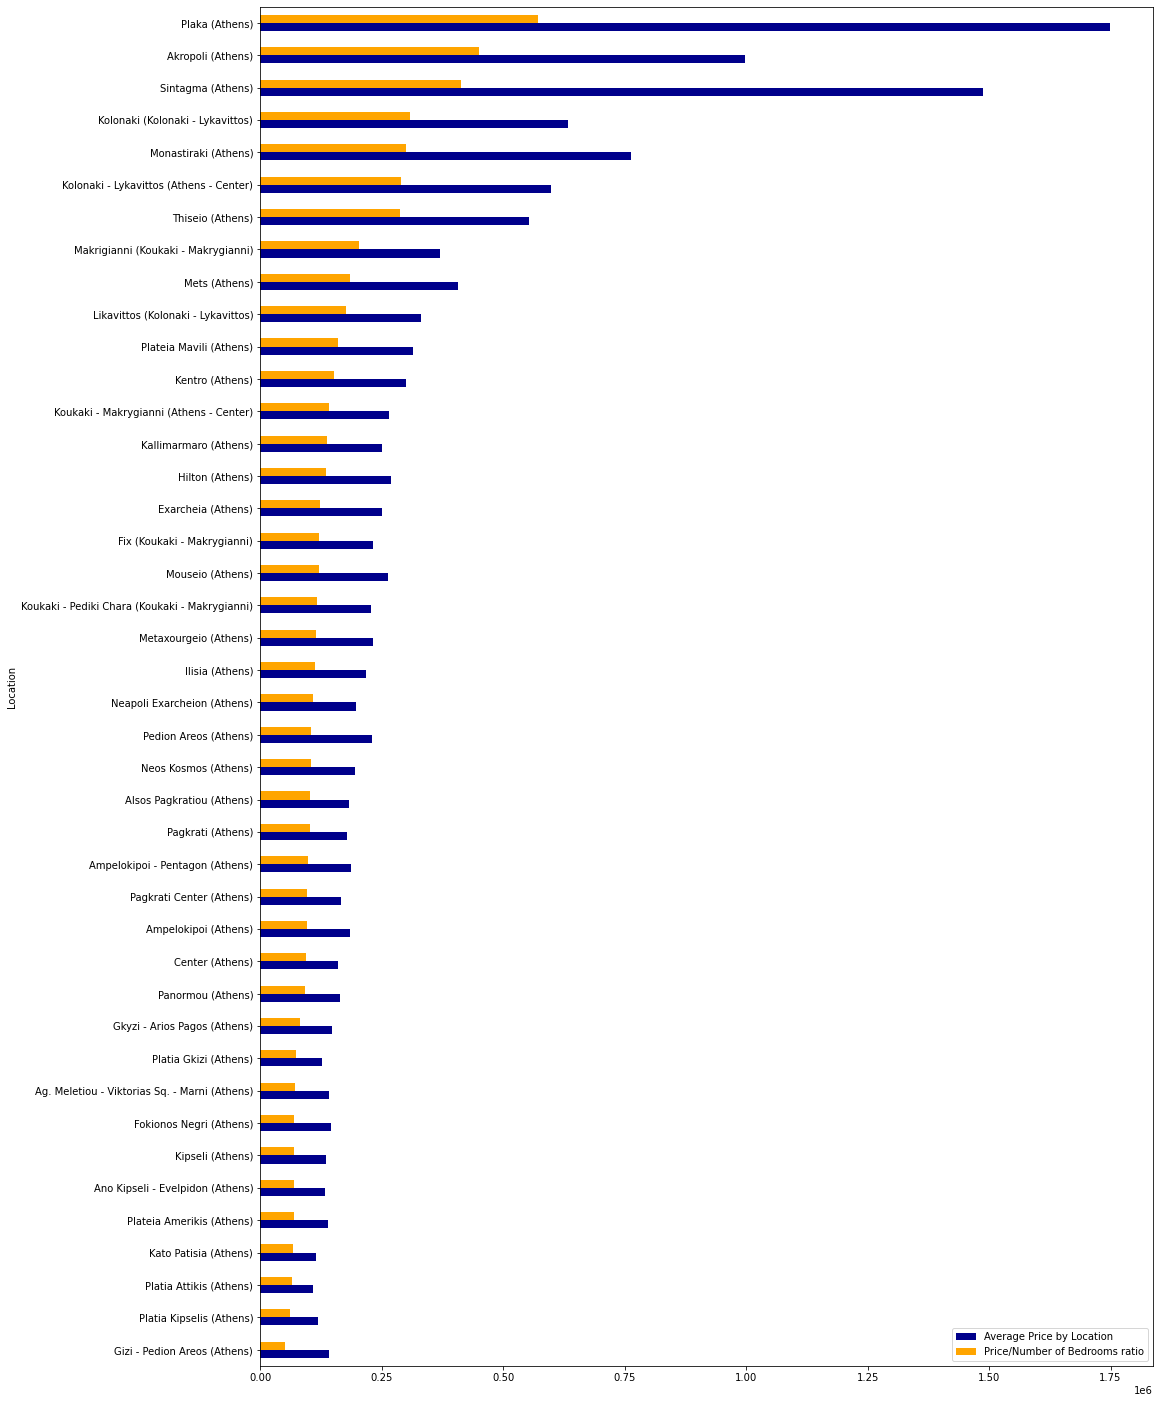

In [60]:
group_1.plot.barh(figsize = (16,25) , color = ['darkblue', 'orange'] )

<AxesSubplot:ylabel='Location'>

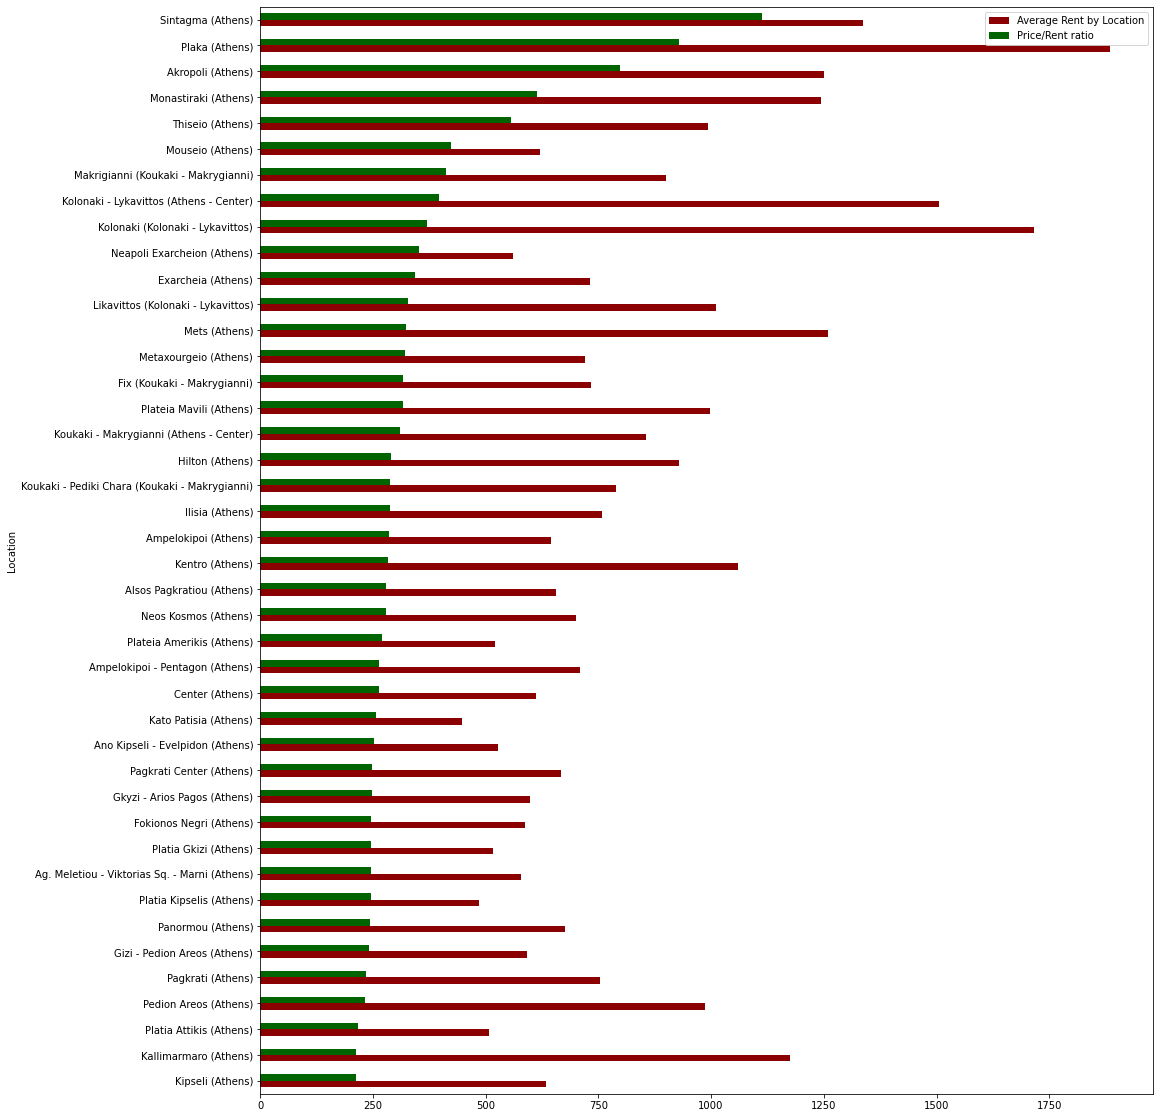

In [61]:
group_2.plot.barh(figsize = (16,20) , color = ['darkred', 'darkgreen'] )

In [62]:
df_merged_final

,Price,Square meters house,Number of Bedrooms,Location,Average Price by Location/# Bedrooms,Average Square meters by Location/# Bedrooms,Average Rent by Location/# Bedrooms,Price per m^2,Average Price per m^2 by Location/# Bedrooms,Average Rent per m^2 by Location/# Bedrooms,Average Price/Rent ratio by Location/# Bedrooms
0,260000.0,98.0,3.0,Alsos Pagkratiou (Athens),297950.00,115.20,1212.50,2653.06,2586.37,10.53,245.73
1,153000.0,64.0,2.0,Alsos Pagkratiou (Athens),188960.67,84.08,740.57,2390.62,2247.39,8.81,255.16
2,62000.0,47.0,1.0,Alsos Pagkratiou (Athens),121759.74,52.61,500.69,1319.15,2314.38,9.52,243.18
3,180000.0,77.0,2.0,Alsos Pagkratiou (Athens),188960.67,84.08,740.57,2337.66,2247.39,8.81,255.16
4,161000.0,70.0,2.0,Alsos Pagkratiou (Athens),188960.67,84.08,740.57,2300.00,2247.39,8.81,255.16
...,...,...,...,...,...,...,...,...,...,...,...
17173,120000.0,75.0,2.0,Ilisia (Athens),194970.00,88.77,836.97,1600.00,2196.35,9.43,232.95
17174,275000.0,130.0,3.0,Ilisia (Athens),304387.76,110.98,1018.00,2115.38,2742.73,9.17,299.01
17175,180000.0,78.0,2.0,Ilisia (Athens),194970.00,88.77,836.97,2307.69,2196.35,9.43,232.95
17176,90000.0,47.0,1.0,Ilisia (Athens),111777.78,54.56,541.43,1914.89,2048.71,9.92,206.45
